## 6. GO/STOP! - Object Detection 시스템 만들기

### [ 목  차 ]
1. 데이터 불러오기
2. 이미지 전처리
3. One stage detector - RetinaNet 사용
4. 모델 작성
5. 모델 학습
6. 결과 확인
7. 자율주행 시스템 만들기
8. 자율주행 시스템 평가하기
9. 결 론    
      
[ 회 고 ]      



### 1. 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 라이버러리 가져오기
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

print('슝=3')

슝=3


In [ ]:
# GPU 연결확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
DATA_DIR = '/content/drive/MyDrive/data'

In [ ]:
# 데이터셋 불러오기
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_DIR,
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

슝=3


In [ ]:
# 데이터셋 클래스 개수
NUM_CLASSES = ds_info.features["objects"]["type"].num_classes
NUM_CLASSES

8

In [ ]:
# 데이터셋 클래스 구성
TYPE_NAMES = ds_info.features["objects"]["type"].names
TYPE_NAMES

['Car',
 'Van',
 'Truck',
 'Pedestrian',
 'Person_sitting',
 'Cyclist',
 'Tram',
 'Misc']

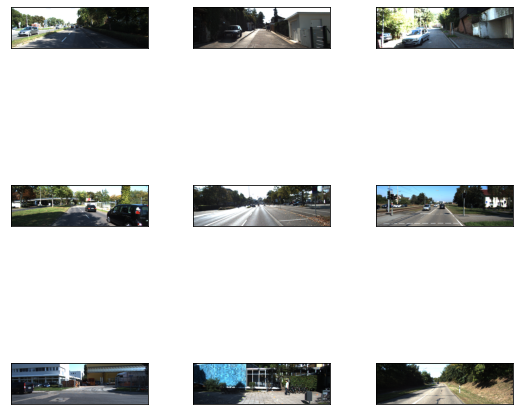

In [ ]:
# 각 이미지 클래스 이미지 확인
_ = tfds.show_examples(ds_train, ds_info)

In [ ]:
# 데이터셋 정보 확인
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(14,), dtype=float32, numpy=
array([-1.97, -1.99, -1.7 , -1.81, -2.11,  2.75,  1.76,  1.93,  1.9 ,
        1.88, -2.99,  1.56,  1.74,  1.67], dtype=float32)>, 'bbox': <tf.Tensor: shape=(14, 4), dtype=float32, numpy=
array([[0.13010696, 0.5862278 , 0.576123  , 0.6344265 ],
       [0.15705882, 0.6571244 , 0.601738  , 0.7072052 ],
       [0.2428075 , 0.19313408, 0.55815506, 0.23378837],
       [0.35665774, 0.5088692 , 0.56002676, 0.5274475 ],
       [0.28037432, 0.6259451 , 0.5853476 , 0.66390955],
       [0.11497326, 0.8804039 , 0.6296524 , 0.97975767],
       [0.2205615 , 0.8873102 , 0.62144387, 0.936042  ],
       [0.27502674, 0.29155898, 0.55122995, 0.32440227],
       [0.24994652, 0.26145396, 0.43826205, 0.3110824 ],
       [0.27093583, 0.26950726, 0.5568984 , 0.2948223 ],
       [0.24264705, 0.86004037, 0.63363636, 0.95084816],
       [0.45516044, 0.42310178, 0.5698396 , 0.457

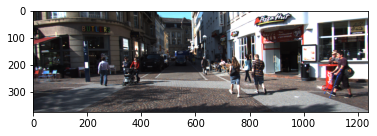

In [ ]:
# 학습용 이미지 확인
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))  # ['image', 'image/file_name', 'objects']
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)
img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()


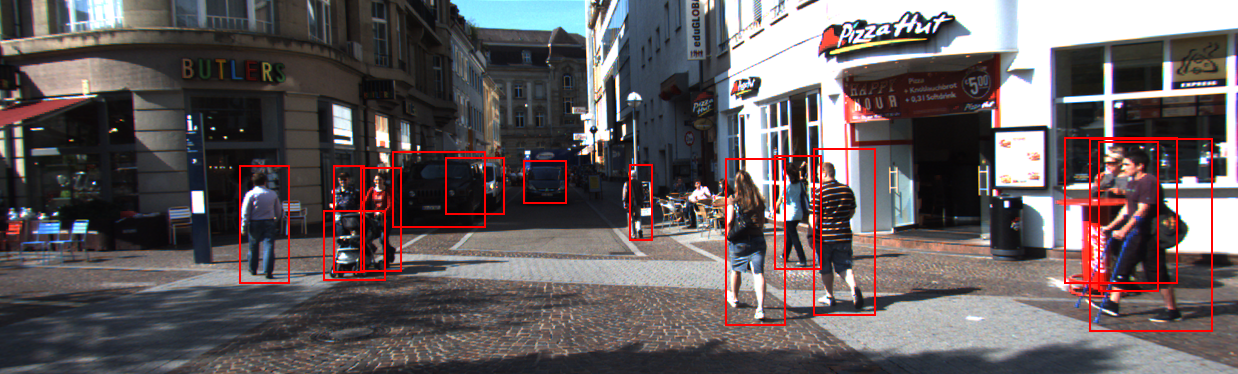

In [ ]:
# 바운딩 박스 시각화
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

### 2. 이미지 전처리

In [ ]:
# x와 y좌표 위치 교체
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

print('슝=3')

슝=3


In [ ]:
# 무작위로 수평 뒤집기(Flip)
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

print('슝=3')

슝=3


In [ ]:
# 이미지 크기 조정 및 패딩 추가
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

print('슝=3')

슝=3


In [ ]:
# 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

print('슝=3')

슝=3


In [ ]:
# 데이터 가공 함수
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

print('슝=3')

슝=3


### 3. One stage detector - RetinaNet 사용

In [ ]:
# AnchorBox 클래스 (AnchorBox: 물체 위치 후보)
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

print('슝=3')

슝=3


In [ ]:
# 입력할 데이터를 Anchor Box에 맞게 변형하는 함수
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

In [ ]:
# IoU 계산 함수
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

print('슝=3')

슝=3


In [ ]:
# 라벨 인코딩 클래스: 라벨을 Anchor Box 에 맞추는 클래스
# IoU가 0.5보다 높으면 물체, 0.4보다 낮으면 배경

class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
    
print('슝=3')

슝=3


In [ ]:
# 데이터 전처리를 위한 파이프라인 생성
BATCH_SIZE = 2

label_encoder = LabelEncoder()

autotune = tf.data.AUTOTUNE
ds_train = ds_train.map(preprocess_data, num_parallel_calls=autotune)
ds_train = ds_train.shuffle(8 * BATCH_SIZE)
ds_train = ds_train.padded_batch(
    batch_size=BATCH_SIZE, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
ds_train = ds_train.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
ds_train = ds_train.prefetch(autotune)

ds_val = ds_val.map(preprocess_data, num_parallel_calls=autotune)
ds_val = ds_val.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
ds_val = ds_val.map(label_encoder.encode_batch, num_parallel_calls=autotune)
ds_val = ds_val.prefetch(autotune)

print('슝=3')

슝=3


### 4. 모델 작성 (RetinaNet)



In [ ]:
# FPN(Feature Pyramid Network) 약간 수정해서 사용

class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

print('슝=3')

슝=3


In [ ]:
# head 생성 함수 : box, class 각각

def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

print('슝=3')

슝=3


In [ ]:
# RetinaNet 의 backbone

def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

print('슝=3')

슝=3


In [ ]:
# RetinaNet 클래스: Backbone + FPN + classification용 head + box용 head

class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

print('슝=3')

슝=3


In [ ]:
# RetinaNet Loss 클래스: Box Loss, Classification Loss

class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

print('슝=3')

슝=3


### 5. 모델 학습

In [ ]:
# 모델 학습 준비
resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(NUM_CLASSES)
model = RetinaNet(NUM_CLASSES, resnet50_backbone)

print('슝=3')

94781440/94765736 [==============================] - 0s 0us/step
슝=3


In [ ]:
# Learning Rate 설정

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# 모델 학습 epoch 및 저장경로

EPOCHS = 15
MODEL_DIR = os.path.join('/content/drive/MyDrive/going_deeper', 'checkpoints')
MODEL_PATH = os.path.join(MODEL_DIR, f'weights_epoch_{EPOCHS}')


In [ ]:
# 모델 학습 함수

def model_fit(model, model_path):
    callbacks_list = [
        # 훈련 중간중간 현재 parameter 값 저장
        tf.keras.callbacks.ModelCheckpoint(
            filepath=model_path,
            monitor="val_loss",
            save_best_only=False,
            save_weights_only=True,
            verbose=1,
        ),
    ]

    history = model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=EPOCHS,
        callbacks=callbacks_list
    )

    return history

In [ ]:
history = model_fit(model, MODEL_PATH)

Epoch 1/15
3173/3173 [==============================] - ETA: 0s - loss: 1.0111 - accuracy: 0.2366
Epoch 1: saving model to /content/drive/MyDrive/going_deeper/checkpoints/weights_epoch_15
3173/3173 [==============================] - 864s 272ms/step - loss: 1.0111 - accuracy: 0.2366 - val_loss: 1.2184 - val_accuracy: 0.2566
Epoch 2/15
3173/3173 [==============================] - ETA: 0s - loss: 0.7313 - accuracy: 0.2277
Epoch 2: saving model to /content/drive/MyDrive/going_deeper/checkpoints/weights_epoch_15
3173/3173 [==============================] - 864s 272ms/step - loss: 0.7313 - accuracy: 0.2277 - val_loss: 1.0895 - val_accuracy: 0.2548
Epoch 3/15
3173/3173 [==============================] - ETA: 0s - loss: 0.5875 - accuracy: 0.2345
Epoch 3: saving model to /content/drive/MyDrive/going_deeper/checkpoints/weights_epoch_15
3173/3173 [==============================] - 865s 272ms/step - loss: 0.5875 - accuracy: 0.2345 - val_loss: 1.0696 - val_accuracy: 0.2129
Epoch 4/15
3173/3173 [===

In [ ]:
# 학습 결과 시각화
def draw_history(history):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Accuracy, Validation Accuracy 시각화
    plt.subplot(122)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.show()

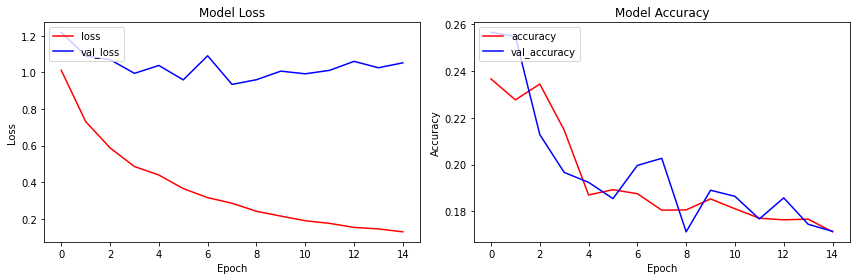

In [ ]:
draw_history(history)

In [ ]:
# 학습한 모델 저장
model.save_weights(MODEL_PATH)
print("Save Model")

Save Model


### 6. 결과 확인

In [ ]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

print('슝=3')

슝=3


In [ ]:
# 추론 가능한 모델 조립

image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

print('슝=3')

슝=3


In [ ]:
# 모델 추론 결과 시각화 함수
car_list = ['Car', 'Van', 'Truck', 'Tram']
people_list = ['Pedestrian', 'Person_sitting', 'Cyclist']

def visualize_detections(
    image, boxes, classes, scores, figsize=(12, 4), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)

    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):

        if _cls in car_list:
            color=[0,1,1]  # 객체가 차량일 경우, 하늘색 설정
        elif _cls in people_list:
            color = [1,1,0]  # 객체가 사람일 경우, 노란색 설정

        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

print('슝=3')

슝=3


In [ ]:
# 추론시 입력 데이터를 전처리 하기 위한 함수
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

print('슝=3')

슝=3


In [ ]:
# Object Detection 결과 시각화

def get_object_detection_result(image):
    int2str = ds_info.features["objects"]["type"].int2str

    image = tf.cast(image, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]

    boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    scores = detections.nmsed_scores[0][:num_detections]

    return image, boxes, class_names, scores

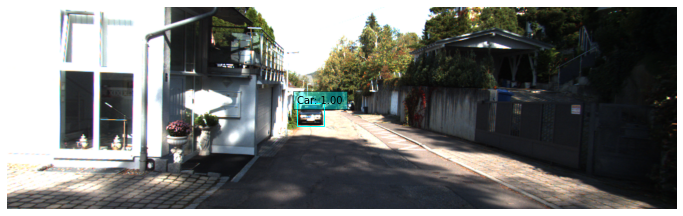

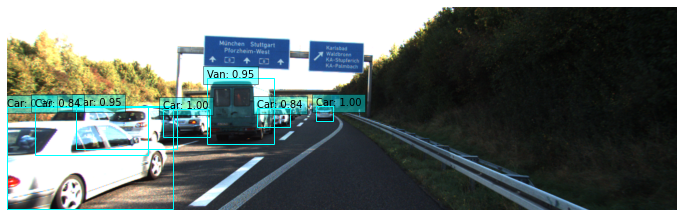

In [ ]:
for sample in ds_test.take(2):
    visualize_detections(*get_object_detection_result(sample["image"]))

### 7. 자율주행 시스템 만들기     
위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

  * 입력으로 이미지 경로를 받습니다.
  * 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
  * 조건은 다음과 같습니다.
    - 사람이 한 명 이상 있는 경우
    - 차량의 크기(width or height)가 300px이상인 경우

In [ ]:
def self_drive_assist(image_path,
                    size_limit=300, to_visualize=False,
                    people_list = ['Pedestrian', 'Person_sitting', 'Cyclist']
):
    image = Image.open(image_path).convert('RGB')
    image = tf.keras.preprocessing.image.array_to_img(image)  #add
    array = tf.keras.preprocessing.image.img_to_array(image)  #add
    image = tf.convert_to_tensor(array, dtype=tf.float32)     #add
#    image = tf.convert_to_tensor(image, dtype=tf.float32)  # not working with PIL
    image, boxes, class_names, scores = get_object_detection_result(image)

    # 시각화
    if to_visualize:
        visualize_detections(image, boxes, class_names, scores)

    # 정지조건 1: 사람 한 명 이상 있는 경우 "Stop"
    if len(set(class_names) & set(people_list)) > 0:
        return "Stop"

    # 정지조건 2: 차량 크기(W,H)가 300px 이상인 경우 "Stop"
    for box, class_name, score in zip(boxes, class_names, scores):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        # print(f"w {w:.2f}, h {h:.2f}, w*h {w*h:.2f}")  # 자동차 크기 출력
        if w >= size_limit or h >= size_limit:
            return "Stop"
            
    # 아니면 "Go"
    return "Go"

In [ ]:
IMAGE_DIR = '/content/drive/MyDrive/going_deeper/images'
image_path_list = [image_path for image_path in os.listdir(IMAGE_DIR) if image_path.endswith('.png')]

for i, image_path in enumerate(image_path_list):
    print(i, image_path)
    print(self_drive_assist(os.path.join(IMAGE_DIR, image_path), size_limit=300, to_visualize=True))
    print('━━━━━━━━━━━━━━━')

Output hidden; open in https://colab.research.google.com to view.

### 8. 자율주행 시스템 평가하기

In [ ]:
# 평가 함수
def test_system(func, IMAGE_DIR):
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = os.path.join(IMAGE_DIR, image_file)
        pred = func(image_path)
        if pred == answer:
            score += 10
        print(f'pred: {pred}, answer: {answer}, score: {score}')
    
    print(f"\n***** {score}점입니다. *****")

In [ ]:
test_system(self_drive_assist, IMAGE_DIR)

pred: Stop, answer: Stop, score: 10
pred: Stop, answer: Stop, score: 20
pred: Stop, answer: Stop, score: 30
pred: Stop, answer: Stop, score: 40
pred: Stop, answer: Stop, score: 50
pred: Go, answer: Go, score: 60
pred: Go, answer: Go, score: 70
pred: Stop, answer: Go, score: 70
pred: Go, answer: Go, score: 80
pred: Go, answer: Go, score: 90

***** 90점입니다. *****


### 9. 결론 및 회고
   * go_3.png 이미지에서 도로에서 먼 곳의 사람이 잡혀서 STOP 판정이 난 것 외에는 모두 정답을 맞춤(90점)
   * 사람의 경우도 STOP기준에 거리(크기)에 따른 판단조건 추가가 필요할 것 같음(문제가 잘못됨 - 사람 있으면 Stop 기준인데)
   * PIL로 불러온 image의 Tensor 변환(tf.convert_to_tensor)이 자꾸 error가 발생하여 tf.keras.preprocessing API로 type변환을 두번하여 우회하는 방식으로 해결함(type error 항상 유의해야겠음)
   * 간단한 자율주행 보조 프로그램도 고려해야 할 게 많은데, 완전 자율주행이 가능할까?     
         
< reference >
  * (paper) Focal Loss for Dense Object Detection, Tsung-Yi Lin, et al.
  * https://herbwood.tistory.com/19
  * https://ropiens.tistory.com/83
  
